<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/focus_MM/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference YAMNet https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb#scrollTo=k2yleeev645r

In [1]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
# import numba
import os
import scipy.fftpack
import cv2
import random
from scipy.special import gamma


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras

import tensorflow_hub as hub

#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

sr = 44100
sr = 16000
sr = 22050

In [2]:
! pip install icecream --quiet
from icecream import ic

In [3]:
! pip install samplerate --quiet
import samplerate

     |████████████████████████████████| 4.0MB 7.8MB/s 


In [4]:
! pip install optuna --quiet
import optuna

     |████████████████████████████████| 307kB 8.6MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 174kB 15.3MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 112kB 15.8MB/s 
     |████████████████████████████████| 143kB 20.2MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 


In [5]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

In [6]:
! pip install audiomentations --quiet
import audiomentations as am

# Get Dataset

In [7]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 19.19 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [8]:
ROOT = '/content/ESC-50/audio/'

data_info = pd.read_csv(ROOT+"../meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))
data_info

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


# Offline input pipeline

In [9]:
class AudioLoader():
    def __init__(self, df, root, format1=False, downsample=True):
        self.df = df
        self.root = root
        self.format1 = format1
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.downsample:
            this_audio = samplerate.resample(this_audio, 16000/44100, converter_type='sinc_fastest')
        if self.format1:
            this_audio = this_audio / 32768     # 2^15 = 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out


def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed


def features_preprocessor(audio_loader, path, df, yamnet, augmentation=0):

    augment = am.Compose([
    am.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    am.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    am.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    am.Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),])


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            _, this_emb, _ = yamnet(this_audio)
            pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
            # break

    if augmentation > 0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    # ic(aug, np.shape(yam_audio))
                    _, this_emb, _ = yamnet(this_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    aug_audio = augment(this_audio, sr)
                    _, this_emb, _ = yamnet(this_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target']], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


        

In [10]:
ic(ROOT)
AUGMENTATION = 0

!mkdir -p feature_storage
path_batch = "/content/feature_storage/"

# download ad set YAMNet pretrained model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

audio_loader = AudioLoader(data_info, ROOT, format1=True)
features_preprocessor(audio_loader, path_batch, data_info, yamnet_model, augmentation=AUGMENTATION)

ic| ROOT: '/content/ESC-50/audio/'


# Sequence class

In [21]:
def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

def mix(a, b, l):
    return l*b + (1-l)*a


class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, alpha_schedule, with_mixup=False):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.with_mixup = with_mixup
        self.epoch = 0
        self.alpha = [0.01, 0.01]
        self.mix_prob = 1
        self.alpha_schedule = alpha_schedule
        # self.a = self.alpha_schedule[0,0]
        # self.b = self.alpha_schedule[1,0]

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.epoch < self.alpha_schedule.shape[1]:
            self.alpha = self.alpha_schedule[:,self.epoch]

        # print('deb alpha', self.alpha[0], self.alpha[1])
        random.shuffle(self.names)

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        # batch_infered = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            # NB fix the axes order from the preprocessor
            this_feat = this_pack[0]
            # this_feat = np.transpose(this_feat, [2,1,0])
            this_target = to_onehot(this_pack[2])
            
            if self.with_mixup:
            # if self.with_mixup:
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                this_feat2 = np.roll(this_feat2, np.random.randint(0,10), axis=0)
                
                this_target2 = to_onehot(this_pack2[2])

                # mix the samples
                l = np.random.beta(self.alpha[0], self.alpha[1])

                this_feat = mix(this_feat, this_feat2, l)

                # this_target = mix(this_target, this_target2, l)   #not mixing target for sample fusion

            batch_feat.append(this_feat)
            batch_target.append(this_target)

        batch_infered = np.array(batch_feat)
        # ic(batch_infered.shape, type(batch_infered))

        batch_target = np.array(batch_target)
        batch_input = batch_infered

        return batch_input, batch_target


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning:

divide by zero encountered in power



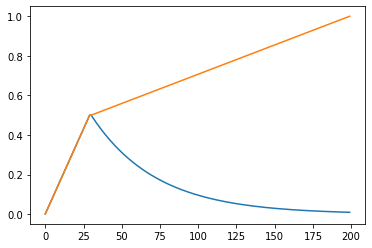

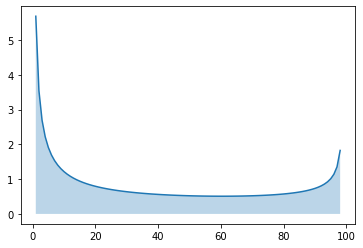

In [16]:
epoch = 200
alpha_schedule = np.zeros((2,epoch))
alpha_start = 1e-3
alpha_end = 0.5
alpha_schedule[:,0] = alpha_start
alpha_schedule[0,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[1,0:30] = np.linspace(alpha_start, alpha_end, 30)
alpha_schedule[:,30:] = alpha_end
# alpha_schedule[0,30:] = np.linspace(alpha_end, 0.001, 170)*np.exp(-np.linspace(0,10, 160))
alpha_schedule[0,30:] = alpha_end*np.exp(-np.linspace(0,4, 170))
alpha_schedule[1,30:] = np.linspace(alpha_end, 1, 170)
plt.figure()
plt.plot(alpha_schedule[0])
plt.plot(alpha_schedule[1])

def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# def check_beta(a,b):
a = alpha_schedule[0,50]
b = alpha_schedule[1,50]
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)
plt.fill_between(range(len(v)),beta, alpha=0.3 )

# Using only transfer learning and no mixed features

In [17]:
def make_tfYAMNet(dense1=100, dense2=100, dense3=50, lr=1e-3):
    act = 'relu'

    input_inf = layers.Input(shape=(None,1024))
    

    inf = layers.GlobalAveragePooling1D()(input_inf)
    # # inf = layers.Flatten()(input_inf)
    # inf = tf.expand_dims(inf, axis=-1)
    # inf = layers.Conv1D(100, 1, padding='same', activation='relu')(inf)
    # inf = layers.Conv1D(100, 1, padding='same', activation='relu')(inf)
    # inf = layers.Conv1D(50, 1, padding='same', activation='relu')(inf)
    # z = layers.GlobalAveragePooling1D()(inf)


    # z = layers.concatenate([inf,rms,cont], axis=1)
    z = layers.Flatten()(inf)
    z = layers.Dense(dense1, activation='relu',)(z)
    z = layers.Dense(dense2, activation='relu',)(z)
    z = layers.Dense(dense3, activation='relu',)(z)
    # z = layers.BatchNormalization()(z)
    z = layers.Dense(50, activation='softmax', name='out_total')(z)

    
    model = keras.Model(inputs=input_inf, outputs=z)
    # model = keras.Model(inputs=[input_inf, input_rms, input_flat], outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

tfyam_net = make_tfYAMNet()
tfyam_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1024)]      0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               102500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
out_total (Dense)            (None, 50)                2550  

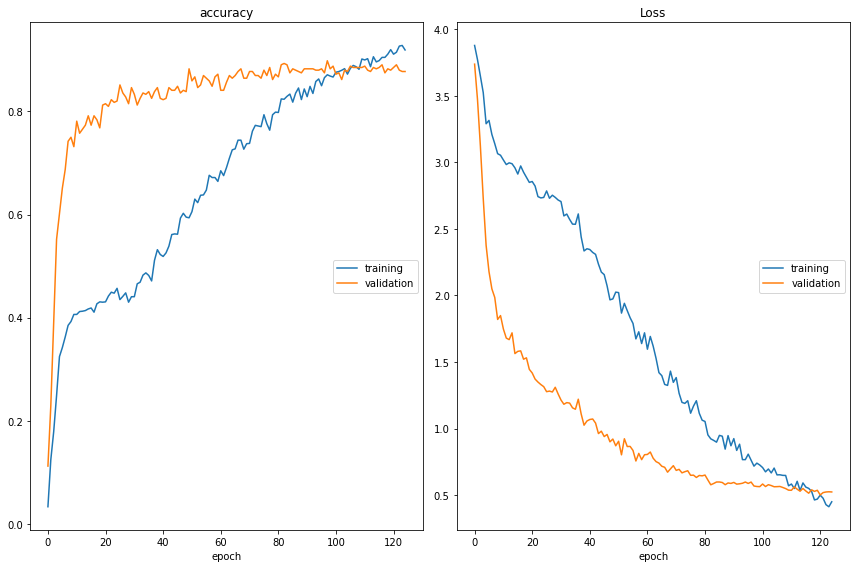

accuracy
	training         	 (min:    0.033, max:    0.928, cur:    0.919)
	validation       	 (min:    0.112, max:    0.898, cur:    0.878)
Loss
	training         	 (min:    0.413, max:    3.878, cur:    0.450)
	validation       	 (min:    0.501, max:    3.738, cur:    0.524)
0.8984375


In [22]:
SOURCE = path_batch

batch_size = 64
epochs = 125

fold = 2
# feat_names  = os.listdir(path_drive)
feat_names  = os.listdir(SOURCE)
ic(len(feat_names))

# not using augmentated samples here
# val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]

train_names = [x for x in feat_names if x[0]!=str(fold) and x.endswith('0.npy')]
val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]

ic(len(train_names))
ic(len(val_names))

train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, with_mixup=True)
val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, with_mixup=False)


ic(len(train_dataloader))
ic(len(val_dataloader))

model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_fold_'+str(fold))
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_file,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)


tfyam_net = make_tfYAMNet(dense1=50, dense2=50, dense3=50)
# Model training
history = tfyam_net.fit(train_dataloader, 
                    epochs=epochs,
                    callbacks=[PlotLossesKeras(), 
                               reduce_lr,
                               model_checkpoint_callback,
                               ],
                    validation_data = val_dataloader,
                    verbose=1)
# load the best model checkpoint
tfyam_net.load_weights(model_checkpoint_file)
best_acc = max(history.history['val_accuracy'])
print(best_acc)


In [ ]:
best_acc = max(history.history['val_accuracy'])
print(best_acc)

0.9036458134651184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in power



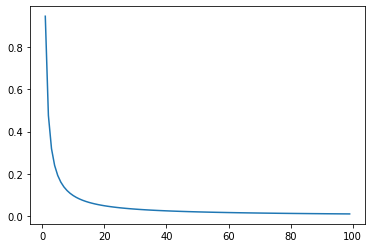

In [ ]:
def beta_density(x, a,b):
    B = (gamma(a)*gamma(b))/gamma(a+b)
    return ((x**(a-1))*(1-x)**(b-1))/B

# def check_beta(a,b):
a = 0.01
b = 1
v = np.linspace(0,1, num=100)
beta = beta_density(v, a, b)
plt.figure()
plt.plot(beta)

# Optuna search

In [ ]:
SOURCE = path_batch
READ_AUG = False
fold = 2

def objective(trial):
   
    epochs = 125
    batch_size = trial.suggest_int('batch_size', 32,256)
    dense1 = trial.suggest_int('dense_1', 50, 200)
    dense2 = trial.suggest_int('dense_2', 50, 200)
    dense3 = trial.suggest_int('dense_2', 50, 200)
    lr = lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)


    # feat_names  = os.listdir(path_drive)
    feat_names  = os.listdir(SOURCE)
    # ic(len(feat_names))

    if READ_AUG:
        train_names = [x for x in feat_names if x[0]!=str(fold)]
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
    else:
        val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
        train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]    

    # ic(len(train_names))
    # ic(len(val_names))

    train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, alpha_schedule, with_mixup=True)
    val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, alpha_schedule, with_mixup=False)


    # ic(len(train_dataloader))
    # ic(len(val_dataloader))

    model_checkpoint_dir = '/content/drive/MyDrive/UNI_ICT/HDA/best_model'
    model_checkpoint_file = os.path.join(model_checkpoint_dir, 'best_model_fold_'+str(fold))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_file,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=5, min_lr=0.00005)


    tfyam_net = make_tfYAMNet(dense1=dense1, dense2=dense2, dense3=dense3, lr=lr)
    # Model training
    history = tfyam_net.fit(train_dataloader, 
                        epochs=epochs,
                        callbacks=[
                                # PlotLossesKeras(), 
                                reduce_lr,
                                model_checkpoint_callback,
                                ],
                        validation_data = val_dataloader,
                        verbose=0)
    # load the best model checkpoint
    tfyam_net.load_weights(model_checkpoint_file)
    best_acc = max(history.history['val_accuracy'])
    
    return best_acc

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2021-06-12 10:42:48,698] A new study created in memory with name: no-name-30c0db47-18b2-43de-bbd3-470af25a2870
[I 2021-06-12 10:48:46,933] Trial 0 finished with value: 0.8802589178085327 and parameters: {'batch_size': 103, 'dense_1': 120, 'dense_2': 55, 'lr': 0.007333584922621711}. Best is trial 0 with value: 0.8802589178085327.
[I 2021-06-12 10:54:13,818] Trial 1 finished with value: 0.8954545259475708 and parameters: {'batch_size': 220, 'dense_1': 189, 'dense_2': 130, 'lr': 0.022398537908252875}. Best is trial 0 with value: 0.8802589178085327.
[I 2021-06-12 10:59:57,559] Trial 2 finished with value: 0.8634920716285706 and parameters: {'batch_size': 105, 'dense_1': 148, 'dense_2': 157, 'lr': 0.007725164205365014}. Best is trial 2 with value: 0.8634920716285706.


val Loss: 0.8634920716285706
Best hyperparameters: {'batch_size': 105, 'dense_1': 148, 'dense_2': 157, 'lr': 0.007725164205365014}


In [ ]:
best_params = trial.params
trials_df = study.trials_dataframe()
trials_df

Comparison with standard mixup

# Comparison with noisy mix up

# Final Demonstration on an audio sequence